# Tutorial 1 - Analyzing scRNA-seq data at the Protein Activity Level

<code style="background:lightgreen;color:black">Add description of the goal of this tutorial. Make sure that ways to load/install the package are updated. Also correct the path to the data (or include a dataset on GitHub, Zenodo or others). Also, fix the number of the sections.</code>

### Setup path and import modules
Setup your path variables in the source as follows:

In [3]:
pyther_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/" # where Pyther is located in the machine
import sys
sys.path.insert(1,pyther_path) # add path to pyther to sys.path

import pyther
import scanpy as sc
import anndata 
import pandas as pd

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

### Step 1. Load a gene expression "signature" at the single-cell level 
Load gene expression signature to be used as input to `pyther` for Protein Activity inference. We store the gene expression signature into an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). Display matrix dimensions with cells on rows and features (genes) on columns (after transposition). <code style="background:lightgreen;color:black">Gene expression signatures can be generated using [...] describe approaches</code>. 
The gene expression signature used in this tutorial was generated from a population of  <span style="color:red">malignant ductal cells</span> from publicly avaiable data from [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y).  

In [4]:
gene_expr_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/Ductal_2.csv"
gene_expr_signature = anndata.read_csv(gene_expr_path).T

gene_expr_signature

AnnData object with n_obs × n_vars = 11315 × 5000

### Step 2. Load a gene regulatory network inferred with ARACNe
Load and inspect lineage-specific gene regulatory network generated with the ARACNe. The current ARACNe network was inferred from <span style="color:red">malingant ductal cells</span> using ARACNe3.See the following manuscript [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542) and [ARACNe-AP](https://pubmed.ncbi.nlm.nih.gov/27153652/) for additional information on current ARACNe implementations. 

In [5]:
network_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Ductal_2.tsv"
                            # path to tsv-formatted ARACNe network
    
network = pd.read_csv(network_path, delimiter="\t")

Display the first 5 interactions in the regulatory network. `mor` and `likelihood` represent the mode of regulation of the given regulator-target pair and the likelihood of the interaction, respectively.

In [6]:
network.head()

,regulator,target,mor,likelihood
0,AATF,CDC42SE2,0.005831,0.999934
1,AATF,EIF4EBP2,0.019100,0.999868
2,AATF,DDB1,0.019182,0.999802
3,AATF,COPB2,0.064825,0.999736
4,AATF,MDM4,0.023039,0.999670


Other algorithms can be used to generate gene regulatory networks, but we recommend postprocessing the output to the suitable dataframe format, with columns displayed above.

Convert the pandas DataFrame interactome to an object of class `Interactome` to enable easier manipulation. Type `help(pyther.Interactome)` to see available methods.

In [7]:
network_interactome = pyther.Interactome('malignant_ductal_interactome', network)

Filter out targets in the `Interactome` that are not present in the gene expression matrix 

In [8]:
network_interactome.filter_targets(gene_expr_signature.var_names)

As an example, display the number of targets of a couple of selected regulators, MYC and SERPINA12.

In [9]:
n_MYC = len(network_interactome.get_reg('MYC')) # number of MYC targets in the network
n_SERPINA12 = len(network_interactome.get_reg('SERPINA12')) # number of SERPINA12 targets in the network

print("The number of targets of MYC and SERPINA12 is " + str(n_MYC) + " and " + str(n_SERPINA12) + ", respectively.")

The number of targets of MYC and SERPINA12 is 118 and 144, respectively.


### Convert the gene expression signature into a protein activity matrix using pyther
`pyther` transforms a gene expression signature into a protein activity matrix by enriched regulon analysis. `pyther` allows using [aREA](https://www.nature.com/articles/ng.3593) (default) and [NaRnEA](https://www.mdpi.com/1099-4300/25/3/542) (by setting `enrichment="narnea"` ) as enrichment methods. We will see how to employ the two methodologies.

#### Method 1 - protein activity inference using aREA
As we have seen (section above), different regulators can potentially have different number of targets. We prune each regulon to have the same number of targets (50 in this case). This step is advisable to avoid regulators with an exceedingly number of targets to dominate those with fewer when computing the NES, thus making NES scores comparable.

In [10]:
network_pruned = network_interactome.copy() # generate a copy of the unpruned network before pruning it
network_pruned.prune(cutoff=50,eliminate=True) # prune interactome to have exactly 50 targets

Now all the regulators in the network have exactly 50 transcriptional targets.

In [11]:
n_MYC = len(network_pruned.get_reg('MYC')) # number of MYC targets in the network
n_SERPINA12 = len(network_pruned.get_reg('SERPINA12')) # number of SERPINA12 targets in the network

print("Number of MYC targets: " + str(n_MYC) + "\nNumber of SERPINA12 targets: " + str(n_SERPINA12))

Number of MYC targets: 50
Number of SERPINA12 targets: 50


<div class="alert alert-block alert-success">
<b></b> Run `pyther` to compute the protein activity matrix (aREA method).
</div>
 
Mandatory inputs to `pyther` are a gene expression signature and a gene regulatory network. We will set the output output to be an `ndarray` (The default output would be an AnnData object).

In [12]:
ProtAct_aREA = pyther.pyther(gex_data=gene_expr_signature, # gene expression signature
                             interactome=network_pruned, # gene regulatory network
                             enrichment = "area",
                             output_type="ndarray",
                             njobs=1,
                             verbose=True)

Preparing the association scores
Computing regulons enrichment with aREA
Rank transforming the data
Computing the likelihood matrix
Computing the modes matrix
Preparing the 1-tailed / 2-tailed matrices
Computing enrichment
Integrating enrichment


`ProtAct_aREA` contains the activity of each regulatory protein - computed as a Normalized Enrichment Score (NES) - for each single cell.

In [13]:
ProtAct_aREA # display the protein activity matrix 

regulator,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB11,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AACACGTCAATGACCT,-0.039933,-0.513357,-0.060472,0.029355,0.065028,-0.010176,-0.034340,-0.002353,0.022366,0.001244,...,-0.299727,0.037092,-0.038729,0.198784,0.024052,-1.026783,-0.209181,-0.071998,0.008095,-0.034638
T1_AACCATGCACAACTGT,-0.011776,-1.068924,-0.018706,0.014480,-0.003866,-0.038899,-0.039349,-0.331106,-0.035347,0.336390,...,0.010091,-0.027395,0.026021,0.364444,0.023505,-0.944922,-0.056033,-0.001513,-0.003964,-0.003518
T1_AACCATGTCTGATTCT,-0.028553,1.330032,-0.004081,0.006825,0.083852,-0.115756,-0.177377,0.773305,-0.036582,-0.000985,...,-0.017797,0.022675,0.553827,-0.100412,0.156821,-1.508245,-0.577091,-0.037150,0.007939,0.037444
T1_AACCATGTCTGTCCGT,-0.014895,-0.915240,-0.045044,0.014684,0.015371,-0.017883,-0.037444,-0.424763,0.024829,0.027476,...,-0.004947,-0.021320,0.001817,0.001134,0.051330,1.204289,-0.133911,-0.007055,0.002797,0.036863
T1_AACCGCGGTACTCGCG,-0.036032,0.510231,0.000235,-0.013971,0.038972,-0.043377,-0.031405,0.588168,0.040598,-0.003533,...,-0.014752,-0.059616,-0.482996,-0.094831,-0.079732,0.980695,0.000199,-0.073101,0.006302,-0.007790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTTCCTCCAGACAAGC,0.055305,0.341894,-0.050933,-0.012951,0.330071,-0.363238,-0.036886,1.088231,-0.017743,-0.056507,...,-0.807568,-0.077548,0.030926,-0.059328,-0.119481,0.833767,1.135612,-0.014460,-0.007370,-0.014418
T24_TTTGCGCCAATCGAAA,-0.004649,1.165203,-0.035998,0.003956,0.110806,0.246218,-0.024395,1.978674,-0.012702,0.047694,...,-0.008036,-0.014472,0.216086,-0.027095,-0.029380,-0.593994,0.005890,-0.002650,-0.083207,-0.063111
T24_TTTGCGCTCTTATCTG,0.043928,1.225162,-0.050975,0.013500,0.076413,0.000560,-0.017487,-1.389864,0.028424,-0.141229,...,-0.006508,0.007948,-0.087531,0.155677,0.658833,-0.711236,1.666220,-0.036570,0.017048,0.051186
T24_TTTGGTTAGACACTAA,0.082392,1.454482,-0.031634,0.034216,0.031895,-0.002404,0.006009,-1.012444,0.041352,-0.080170,...,0.023045,-0.004660,-0.044410,0.613269,0.012293,0.731556,-0.049039,-0.058118,-0.000430,0.003444


#### Method 2 - protein activity inference using (matrix)-NaRnEA

<div class="alert alert-block alert-success">
<b></b> Run `pyther` to compute the protein activity matrix (matrix-NaRnEA method).
</div>
 

Compute the protein activity using `pyther` with NaRnEA as the enrichment method. Unlike aREA, NaRnEA is designed to run with regulons of different sizes, i.e. different number of targets per regulator. <code style="background:lightgreen;color:black">Comment on modes to compute the qnorm with C++ or approx.</code>

In this example, we will set the output to be an `AnnData` object (default).

In [14]:
ProtAct_NaRnEA = pyther.pyther(gex_data=gene_expr_signature, # gene expression signature
                                 interactome=network_interactome, # gene regulatory network
                                 enrichment = "narnea",
                                 njobs=1,
                                 output_type="anndata",
                                 verbose=True)

Preparing the association scores
Computing regulons enrichment with NaRnEa
reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...


Show the output type and length of `ProtAct_NaRnEA`.

In [15]:
ProtAct_NaRnEA # display the protein activity matrix as AnnData object 

AnnData object with n_obs × n_vars = 11315 × 6603
    uns: 'gex_data'
    layers: 'pes'

When using NaRnEA, `pyther` returns an additional layer, `pes` that stores the Proportional Enrichment Scores (PES) for regulator, a measure bound in the interval $-1 \le PES \le 1$ that can be used as a measure of effect size. For further details, see [Griffin et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36981431/).
Display NES and PES protein activity matrices.


In [16]:
ProtAct_NaRnEA.to_df() # NES matrix

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB11,ABCB4,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AACACGTCAATGACCT,5.327945,-3.829106,-1.332991,1.873096,-0.892105,6.755131,-1.064186,-0.214509,0.655739,-2.730240,...,-0.561347,3.032530,-4.234940,-4.994237,0.554516,-2.147837,-2.542359,6.295967,2.433687,-3.778648
T1_AACCATGCACAACTGT,-5.766196,-5.639013,2.082483,-1.304688,-0.585171,-5.065806,0.758858,-0.530448,-0.278866,-3.444015,...,0.304809,-3.790693,-4.527736,-4.580476,0.387778,-1.847651,1.663134,5.029084,-2.721949,-3.973836
T1_AACCATGTCTGATTCT,-2.802891,3.993644,-3.051991,-2.714661,-0.384352,3.662242,0.521085,-0.527517,0.372198,-1.648475,...,0.454476,3.489575,4.389804,-5.389578,0.883337,1.698302,2.500381,5.306106,-3.180748,2.932764
T1_AACCATGTCTGTCCGT,5.836132,-5.163541,-1.977321,1.141605,0.463444,-6.424187,-0.517844,-0.151439,0.292964,2.459056,...,0.677739,-4.344269,-4.531244,-3.883833,0.974688,3.148598,-1.666538,6.374284,-2.399883,-4.054550
T1_AACCGCGGTACTCGCG,-4.609296,-4.227212,-1.493042,1.699813,-0.501248,-3.764099,-1.001384,0.410246,-0.586248,3.430812,...,1.612769,-3.468153,5.620489,-5.189224,-1.049103,1.246936,1.916292,4.120426,-2.854428,-3.290125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTTCCTCCAGACAAGC,-3.944360,1.750139,1.451235,1.311981,-1.013225,3.335825,-1.223036,-1.361282,1.000266,-2.621334,...,-1.175710,-2.760639,-2.704699,7.001897,-0.767698,-1.361584,-1.866684,1.358097,-3.493935,3.254662
T24_TTTGCGCCAATCGAAA,3.347529,4.500856,1.888104,1.250957,0.436190,4.848531,-0.517327,0.351717,-0.559568,2.491276,...,0.848876,4.110682,-4.246705,-3.352188,0.562731,-1.935355,-3.241285,-4.374495,-2.481064,-3.616688
T24_TTTGCGCTCTTATCTG,5.555337,-6.153196,1.372226,2.919869,-0.469186,-4.349864,-0.890229,0.190666,-0.334211,4.079427,...,0.413367,-3.362867,-3.973336,-4.882912,-0.877738,-1.255162,-1.605664,-5.820206,-3.754081,-3.087651
T24_TTTGGTTAGACACTAA,5.937774,-5.224112,1.148214,2.144821,0.292466,-4.405517,0.710239,0.310628,-0.301723,2.331352,...,-1.071508,-3.368961,-5.275390,-4.463356,-0.697124,3.595052,-2.047085,4.147670,-2.876362,-3.277021


In [17]:
ProtAct_NaRnEA.to_df(layer="pes") # PES matrix

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB11,ABCB4,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AACACGTCAATGACCT,0.348869,-0.343762,-0.110863,0.130743,-0.070393,0.429836,-0.083036,-0.016585,0.048539,-0.204628,...,-0.042109,0.199476,-0.374441,-0.424743,0.045133,-0.184836,-0.209920,0.377255,0.157716,-0.348309
T1_AACCATGCACAACTGT,-0.528985,-0.529745,0.129780,-0.112411,-0.045484,-0.476095,0.050026,-0.039604,-0.022121,-0.246433,...,0.023831,-0.344766,-0.417133,-0.411367,0.030728,-0.163514,0.107172,0.263967,-0.233501,-0.380075
T1_AACCATGTCTGATTCT,-0.237848,0.282956,-0.249395,-0.227694,-0.030584,0.261185,0.038871,-0.042016,0.029066,-0.128803,...,0.036971,0.254114,0.310455,-0.427258,0.073448,0.121923,0.187542,0.360094,-0.258316,0.218576
T1_AACCATGTCTGTCCGT,0.357353,-0.476673,-0.165278,0.075627,0.031755,-0.593634,-0.040014,-0.011453,0.020916,0.187330,...,0.053423,-0.390363,-0.410869,-0.341585,0.077991,0.191551,-0.137638,0.352367,-0.204059,-0.382293
T1_AACCGCGGTACTCGCG,-0.407796,-0.377861,-0.124176,0.119877,-0.039662,-0.337172,-0.078353,0.031478,-0.047480,0.267631,...,0.129462,-0.305022,0.360090,-0.439009,-0.082259,0.081976,0.134811,0.250632,-0.239141,-0.302241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTTCCTCCAGACAAGC,-0.328229,0.130586,0.111119,0.102934,-0.081034,0.250359,-0.096691,-0.110021,0.080107,-0.208949,...,-0.094689,-0.229202,-0.221325,0.485909,-0.063650,-0.110826,-0.152276,0.097389,-0.279884,0.254283
T24_TTTGCGCCAATCGAAA,0.245833,0.322864,0.140398,0.095364,0.033130,0.350021,-0.040649,0.027898,-0.045677,0.198549,...,0.069061,0.302551,-0.352562,-0.262604,0.046824,-0.159023,-0.264329,-0.353943,-0.200182,-0.315115
T24_TTTGCGCTCTTATCTG,0.370068,-0.547986,0.094530,0.206557,-0.037103,-0.388237,-0.069612,0.014642,-0.027056,0.318304,...,0.033178,-0.294894,-0.348749,-0.411278,-0.068900,-0.107469,-0.132508,-0.503978,-0.313703,-0.282752
T24_TTTGGTTAGACACTAA,0.379612,-0.474672,0.076573,0.146992,0.020565,-0.400918,0.049243,0.023502,-0.024292,0.180007,...,-0.079497,-0.299638,-0.471610,-0.385100,-0.053803,0.228075,-0.169294,0.241421,-0.242938,-0.305075


Notice that when setting the `pyther` output to be an object of class `AnnData`, the input gene expression `AnnData` is stored under the attribute `gex_data`:

In [18]:
ProtAct_NaRnEA.uns["gex_data"][0:5,0:5].to_df()

,RP11-206L10.2,RP11-54O7.3,HES4,ISG15,AGRN
T1_AACACGTCAATGACCT,-0.068999,-0.023360,-0.616169,-1.668614,7.155818
T1_AACCATGCACAACTGT,-0.051544,-0.014172,2.159164,-0.277659,-0.480383
T1_AACCATGTCTGATTCT,-0.081841,-0.030217,-0.731943,-0.967582,0.156287
T1_AACCATGTCTGTCCGT,-0.053397,-0.015141,-0.466018,0.654629,-0.501795
T1_AACCGCGGTACTCGCG,-0.073019,-0.025496,-0.653355,-1.721549,1.645273


### Step 4. Analyze single-cells at the Protein Activity level 
We present some basic, but instructive analyses at the protein activity matrix. Start by running Principal Components Analysis (PCA) on the PES matrix, to reduce the dimensionality of the dataset. Use the PCA function avaiable through `pyther.tl`, a module that provides several wrappers to `scanpy.tl` which simplifies the transformation of protein activity data. For instance, functions from `pyther.tl` allow subsetting the class of regulatory proteins to analyze. Run PCA using by projecting the PES of transcriptional regulators (TFs) and co-transcriptional regulators (coTFs) only by setting `filter_by_feature_groups=["tfs", "cotfs"]`. Possible options for this parameter are `["tfs", "cotfs", "sig", "surface"]`, where the latter refer to signaling proteins and surface markers, respectively.

In [27]:
pyther.tl.pca(ProtAct_NaRnEA, layer="pes", filter_by_feature_groups=["tfs", "cotfs"], zero_center=True,  svd_solver='arpack')

Compute the neighbors graph of cells using the PCA representation of the protein activity matrix. For sake of simplicity, we set 10 nearest neightbors and 50 principal components. Typically, these parameters need tuning.

In [78]:
sc.pp.neighbors(ProtAct_NaRnEA, metric="euclidean", n_neighbors=10, n_pcs=50)

Cluster at protein activity using the Leiden algorithm with `resolution=0.2` (in real applications this parameter should be optimized) <code style="background:lightgreen;color:black">How does the leiden option with tfs and cotfs exactly work?.</code>

In [81]:
sc.tl.leiden(ProtAct_NaRnEA, resolution=0.2, n_iterations=-1)

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/tools/_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


Generate a [UMAP](https://arxiv.org/abs/1802.03426) embedding of the previously computed graph, filtering by `"tfs"` and `"cotfs"`. In this example, we focus on TFs and coTFs because we are interested in proteins involved in transcriptional regulation and that are mechanistic determinants of cell state, as shown in [Paull et al., 2021](https://www.sciencedirect.com/science/article/pii/S0092867420316172?via%3Dihub) and [Califano & Alvarez, 2016](https://www.nature.com/articles/nrc.2016.124) .

In [83]:
pyther.tl.umap(ProtAct_NaRnEA, filter_by_feature_groups=['tfs', 'cotfs'])

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}


Display the 2-dimensional UMAP embedding with the corresponding function from the `pyther.pl`, a module that provides wrappers for `scanpy.pl` functions for enhanced visualization of key protein activity features. Color by cluster.  

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


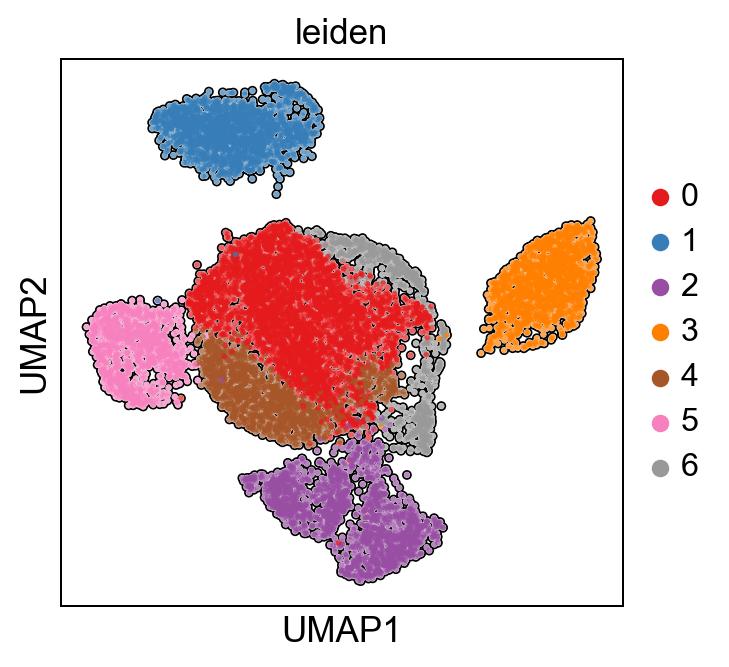

In [84]:
sc.set_figure_params(dpi=90)
n_cells = ProtAct_NaRnEA.shape[0]
dot_size = 120000 / n_cells*2
pyther.pl.umap(ProtAct_NaRnEA, color='leiden', palette="Set1", size=dot_size,add_outline=True)

Find the regulatory proteins predicted to be most active for each cell type by integrating the NES of each regulatory protein across all cells of a given cell type using the Stouffer's method: $$ NES^C_j = \frac{\sum_{k \in C}NES_{k,j}}{\sqrt{n^C}} $$ where $NES^C_j$ denotes the integrated NES for regulator $j$ in cluster/cell type $C$, $NES_{k,j}$ is the NES of regulator $j$ in cluster/cell type $C$ and $n^C$ is the number of cells in cluster $C$.

In [59]:
NES_integrated = pyther.compute_cluster_stouffer_anndata(ProtAct_NaRnEA, "leiden") # Stouffer integration 

Analogously, `compute_cluster_stouffer`, can be used to perform the same operations in Pandas DataFrames. Remove ribosomal proteins from the above matrix (ribosomal protein genes are among the most highly expressed genes in most cell types).

In [60]:
filtered_proteins = NES_integrated.var_names[~NES_integrated.var_names.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated[:,filtered_proteins] # remove ribosomal proteins from the AnnData object

Slice `NES_integrated` to contain only on TFs and coTFs and focus only on these proteins. 

In [140]:
TFs_list = pyther.load.load_TFs(species="human") # load list of TFs
coTFs_list = pyther.load.load_coTFs(species="human") # load list of coTFs
TFs_coTFs = TFs_list + coTFs_list # concatenate TFs and coTFs

NES_integrated = NES_integrated[:,NES_integrated.var_names.isin(TFs_coTFs)] # slice NES_integrated to have only TFs and coTFs

Extract the 5 most activated regulatory protein in each cluster

In [141]:
active_proteins = NES_integrated.to_df().apply(lambda row: row.nlargest(10).index.tolist(), axis=1)  # the top 10 most activated proteins in each cell type
active_proteins

0    [NFKBIZ, LRRFIP1, AGRN, MMP14, NFE2L2, KMT2A, ...
1    [PFDN5, NACA, BTF3, ZNF90, YBX1, NME2, POLR2L,...
2    [CREB3L1, JUND, MUC1, CDH1, ONECUT2, ELF3, LMO...
3    [BTF3, PFDN5, ZNF581, YBX1, NACA, HMGA1, ZNF90...
4    [ENO1, PTOV1, CEBPB, UBE2I, JUN, JUNB, SLC2A4R...
5    [KLF2, ATP8B1, MYRF, ZBTB44, FOXQ1, HDGF, KLF5...
dtype: object

Show the top activated proteins on a heatmap

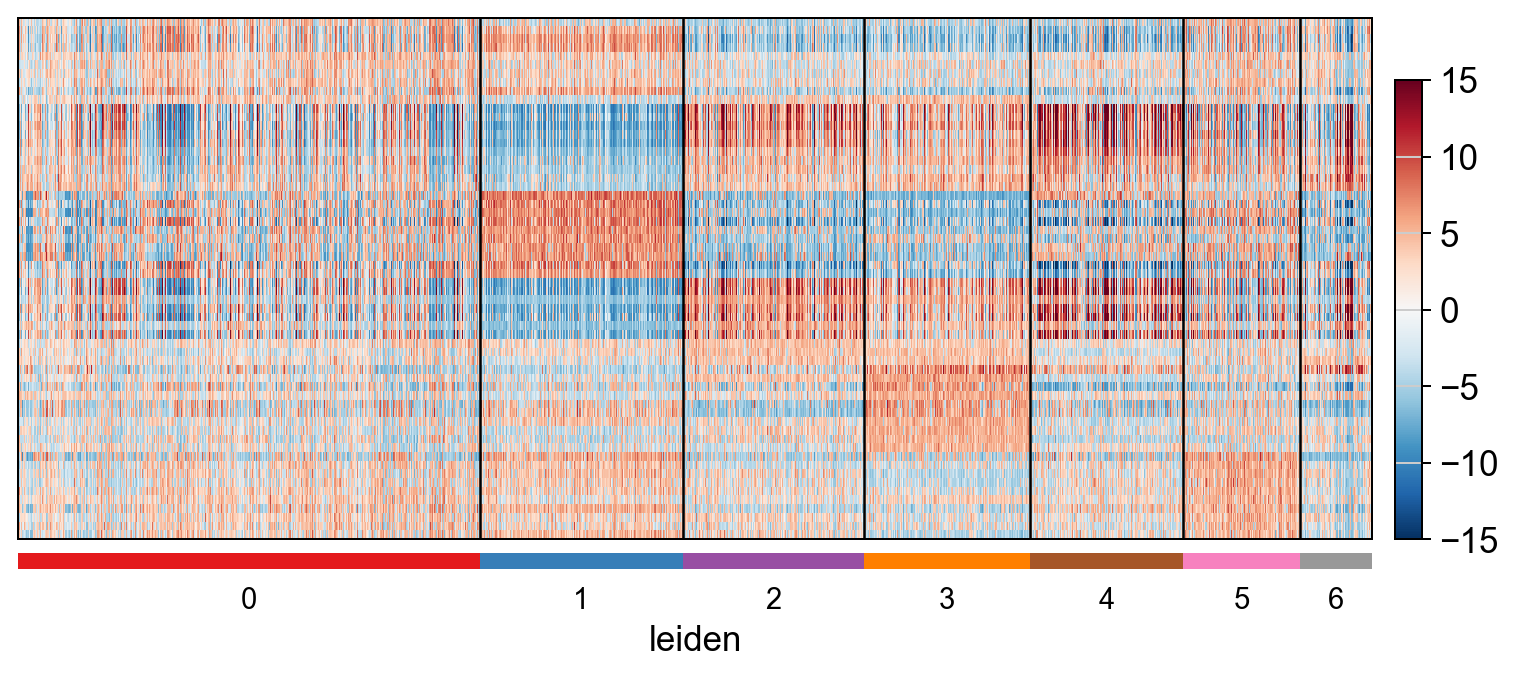

In [149]:
protein_set = active_proteins.sum() # protein set to display on the heatmap
ax = pyther.pl.heatmap(ProtAct_NaRnEA, var_names=protein_set, groupby="leiden",vmin=-15,vmax=15, vcenter=0,cmap="RdBu_r",dendrogram=False,swap_axes=True, show_gene_labels=False)

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


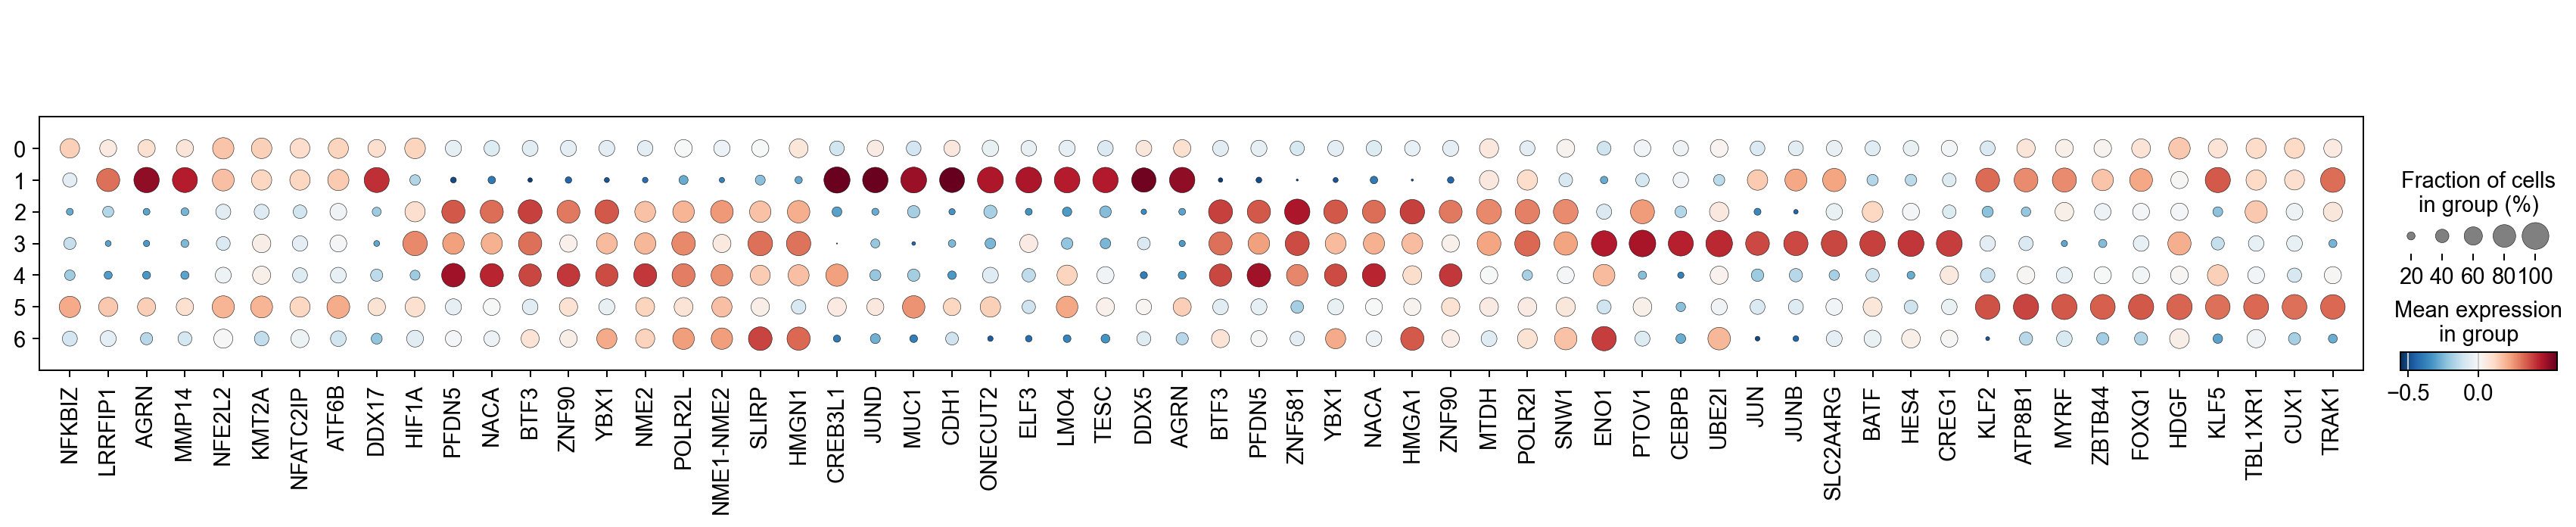

In [154]:
pyther.pl.dotplot(ProtAct_NaRnEA, var_names=protein_set, layer="pes",groupby='leiden', cmap="RdBu_r", vcenter=0,dendrogram=False)

In [156]:
help(sc.tl.leiden)

Help on function leiden in module scanpy.tools._leiden:

leiden(adata: anndata._core.anndata.AnnData, resolution: float = 1, *, restrict_to: Optional[Tuple[str, Sequence[str]]] = None, random_state: Union[NoneType, int, numpy.random.mtrand.RandomState] = 0, key_added: str = 'leiden', adjacency: Optional[scipy.sparse._matrix.spmatrix] = None, directed: bool = True, use_weights: bool = True, n_iterations: int = -1, partition_type: Optional[Type[leidenalg.VertexPartition.MutableVertexPartition]] = None, neighbors_key: Optional[str] = None, obsp: Optional[str] = None, copy: bool = False, **partition_kwargs) -> Optional[anndata._core.anndata.AnnData]
    Cluster cells into subgroups [Traag18]_.
    
    Cluster cells using the Leiden algorithm [Traag18]_,
    an improved version of the Louvain algorithm [Blondel08]_.
    It has been proposed for single-cell analysis by [Levine15]_.
    
    This requires having ran :func:`~scanpy.pp.neighbors` or
    :func:`~scanpy.external.pp.bbknn` first.

In [157]:
?sc.pp.neighbors

Signature:
sc.pp.neighbors(
    adata: anndata._core.anndata.AnnData,
    n_neighbors: int = 15,
    n_pcs: Optional[int] = None,
    use_rep: Optional[str] = None,
    knn: bool = True,
    random_state: Union[NoneType, int, numpy.random.mtrand.RandomState] = 0,
    method: Optional[Literal['umap', 'gauss', 'rapids']] = 'umap',
    metric: Union[Literal['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'], Literal['braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'], Callable[[numpy.ndarray, numpy.ndarray], float]] = 'euclidean',
    metric_kwds: Mapping[str, Any] = mappingproxy({}),
    key_added: Optional[str] = None,
    copy: bool = False,
) -> Optional[anndata._core.anndata.AnnData]
Docstring:
Compute a neighborhood graph of observations [McInnes18]_.

The neighbor search efficiency of this heavily rel

In [158]:
help(sc.pl.umap)

Help on function umap in module scanpy.plotting._tools.scatterplots:

umap(adata: anndata._core.anndata.AnnData, *, color: Union[str, Sequence[str], NoneType] = None, gene_symbols: Optional[str] = None, use_raw: Optional[bool] = None, sort_order: bool = True, edges: bool = False, edges_width: float = 0.1, edges_color: Union[str, Sequence[float], Sequence[str]] = 'grey', neighbors_key: Optional[str] = None, arrows: bool = False, arrows_kwds: Optional[Mapping[str, Any]] = None, groups: Optional[str] = None, components: Union[str, Sequence[str]] = None, dimensions: Union[Tuple[int, int], Sequence[Tuple[int, int]], NoneType] = None, layer: Optional[str] = None, projection: Literal['2d', '3d'] = '2d', scale_factor: Optional[float] = None, color_map: Union[matplotlib.colors.Colormap, str, NoneType] = None, cmap: Union[matplotlib.colors.Colormap, str, NoneType] = None, palette: Union[str, Sequence[str], cycler.Cycler, NoneType] = None, na_color: Union[str, Tuple[float, ...]] = 'lightgray', na